In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from Utils.visualize import display_images
from Utils.utils import log
from Config.CustomConfig import NucleusConfig
from data.CustomDataset import NucleusDataset
from Utils import visualize
from Utils.utils import extract_bboxes, resize_image, resize_mask, generate_pyramid_anchors
from data.DataGenerator import load_image_gt, data_generator
from Utils.network_utils import compute_backbone_shapes
from Utils.utils import parse_image_meta, unmold_image, apply_box_deltas

Using TensorFlow backend.


In [2]:
# ROOT_DIR = os.path.abspath('.')
ROOT_DIR = 'D:\\coursera\\maskrcnn'
MODEL_DIR = os.path.join(ROOT_DIR, "checkpoint")
HORSE_DIR = 'D:\\DataSet\\data-science-bowl-2018'

ROOT_DIR, MODEL_DIR

('D:\\coursera\\maskrcnn', 'D:\\coursera\\maskrcnn\\checkpoint')

In [3]:
dataset = NucleusDataset()
dataset.load_nucleus(HORSE_DIR, "train")
dataset.prepare()

536it [00:00, 53732.00it/s]


In [4]:
config = NucleusConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 536
Class Count: 2
  0. BG                                                
  1. nucleus                                           


39


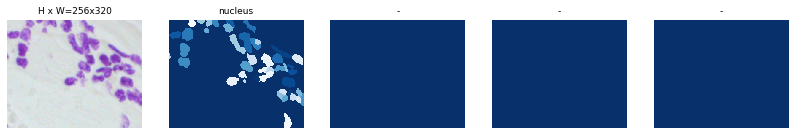

101


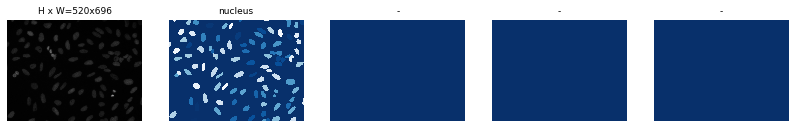

2


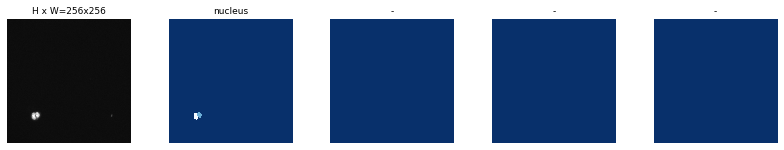

101


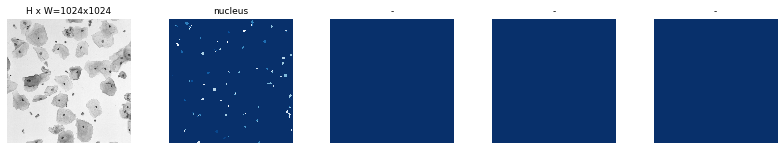

In [12]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(len(class_ids))
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  469 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
image                    shape: (256, 320, 3)         min:   16.00000  max:  243.00000  uint8
mask                     shape: (256, 320, 62)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (62,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (62, 4)               min:    0.00000  max:  320.00000  int32


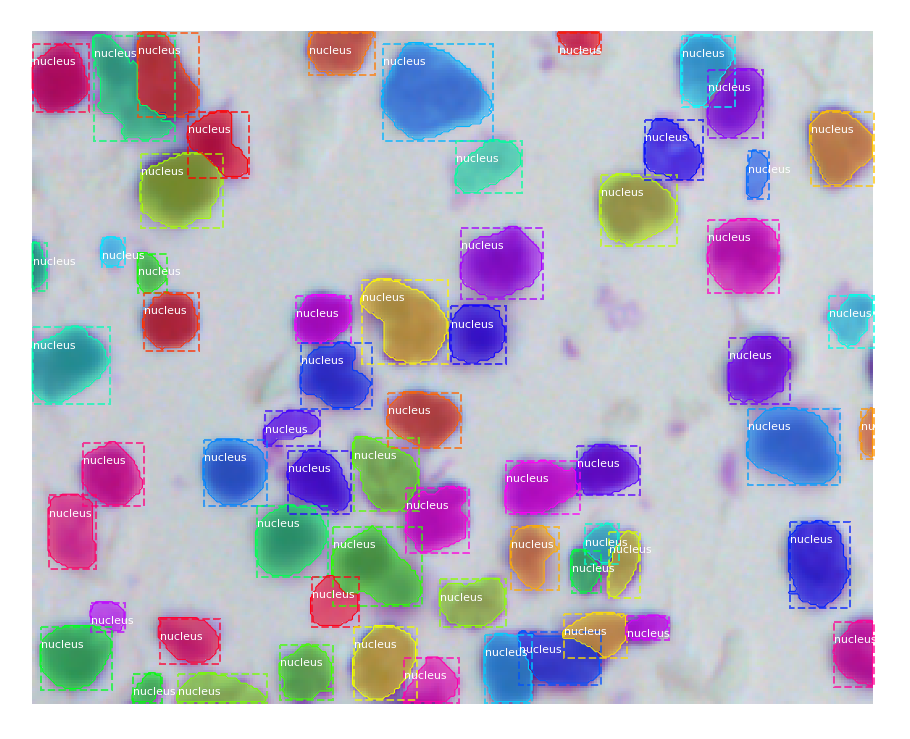

In [15]:
image_id = random.choice(dataset.image_ids)
# image_id = 212
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  414 a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0
Original shape:  (256, 256, 3)
image                    shape: (512, 512, 3)         min:    1.00000  max:  106.00000  uint8
mask                     shape: (512, 512, 44)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (44,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (44, 4)               min:    0.00000  max:  512.00000  int32


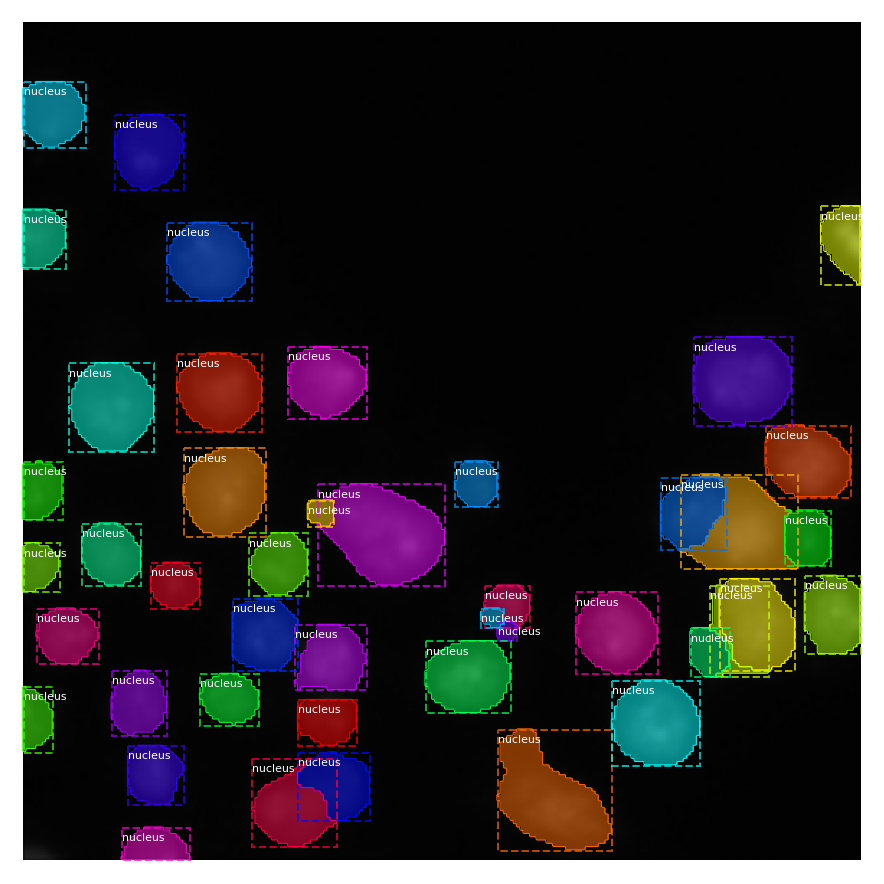

In [21]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
# image_id = 212
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, crop = resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = resize_mask(mask, scale, padding, crop)
# Compute Bounding box
bbox = extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (512, 512, 3)         min:    3.00000  max:  155.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  float64
class_ids                shape: (46,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (46, 4)               min:    0.00000  max:  512.00000  int32
mask                     shape: (512, 512, 46)        min:    0.00000  max:    1.00000  bool


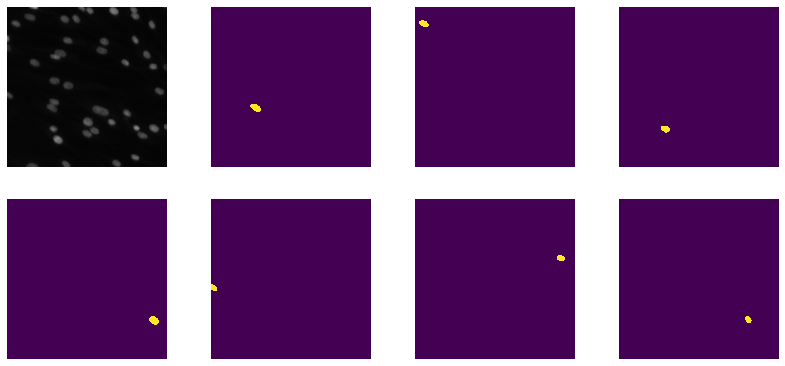

In [26]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = load_image_gt(dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

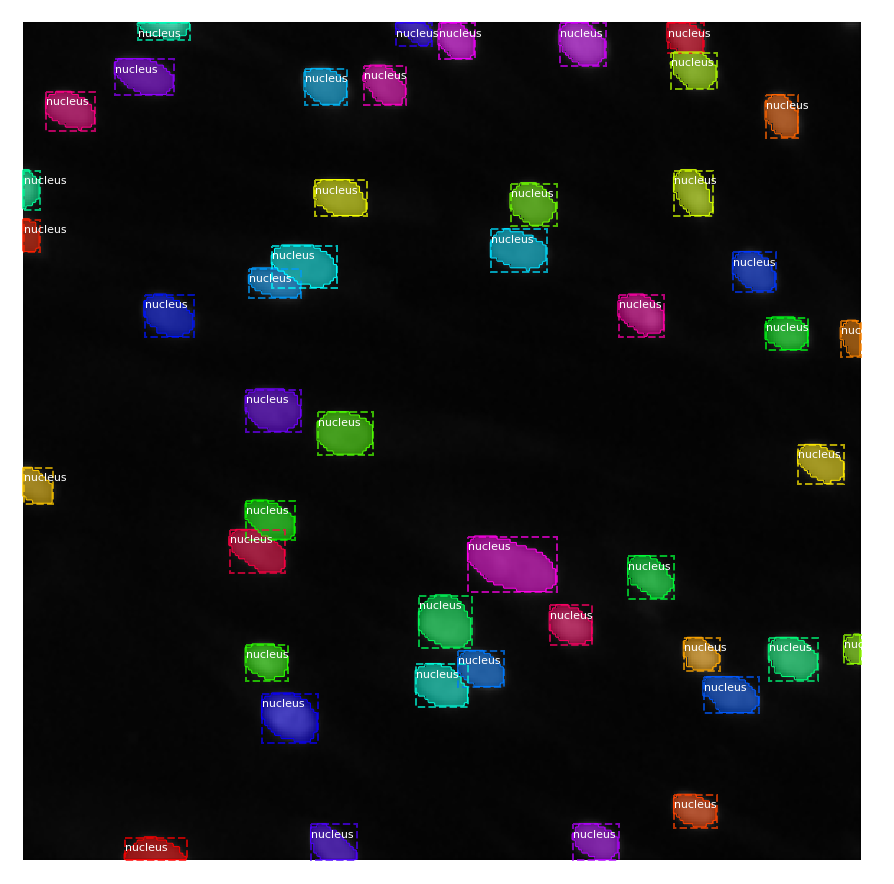

In [27]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 46)          min:    0.00000  max:    1.00000  bool


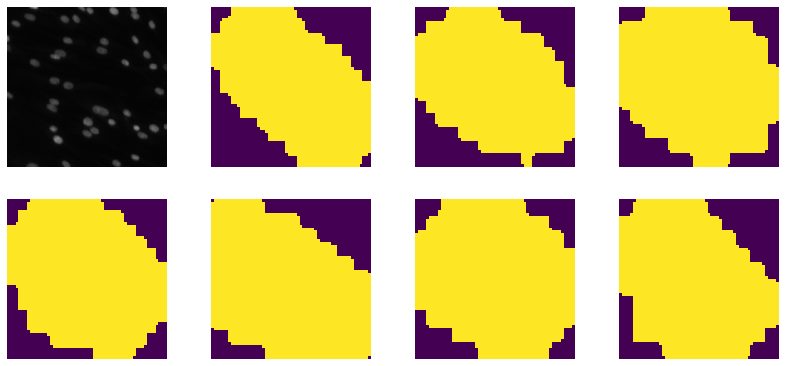

In [28]:
image, image_meta, class_ids, bbox, mask = load_image_gt(dataset, config, image_id, augment=False, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [6]:
# Generate Anchors
backbone_shapes = compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (16, 32, 64, 96, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


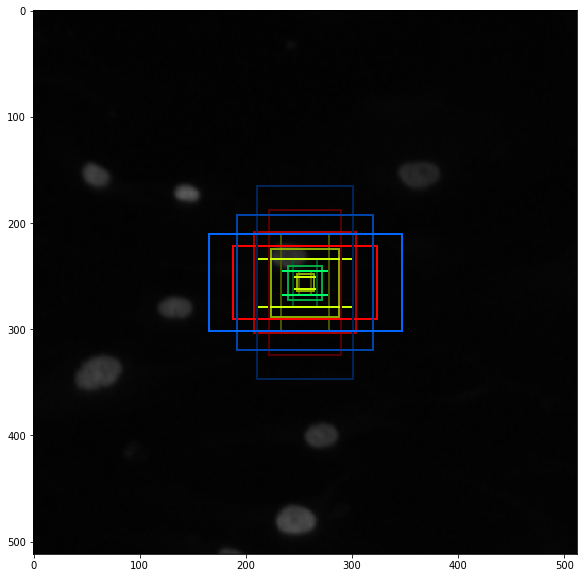

In [7]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

In [8]:
random_rois = 2000
g = data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [9]:
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 128, 4)           min:    0.00000  max:  511.00000  int32
mrcnn_class_ids          shape: (4, 128, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 128, 2, 4)        min:   -2.99559  max:    2.69231  float32
mrcnn_mask               shape: (4, 128, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 150)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 150, 4)           min:    0.00000  max:  512.00000  int32
gt_masks                 shape: (4, 56, 56, 150)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -8.66434  max:    2.65165  float64
image_id:  453 cfabf7379c5591d40aa4a20c86b4197c6a25ab55887a9fca4f06c2dfc0f0e973


anchors                  shape: (65472, 4)            min:  -90.50967  max:  547.88225  float64
refined_anchors          shape: (17, 4)               min:   -0.00000  max:  512.00000  float32
Positive anchors: 17
Negative anchors: 239
Neutral anchors: 65216
BG                     : 101
nucleus                : 27


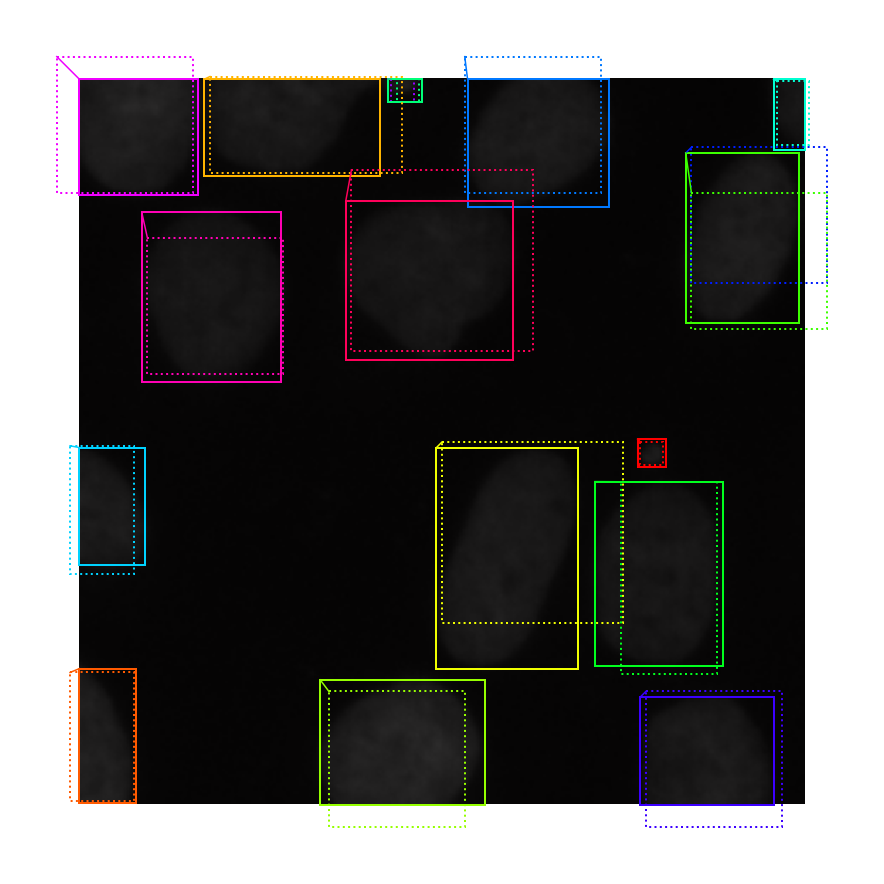

In [10]:
b = 0

# Restore original image (reverse normalization)
sample_image = unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], refined_boxes=refined_anchors, ax=ax)

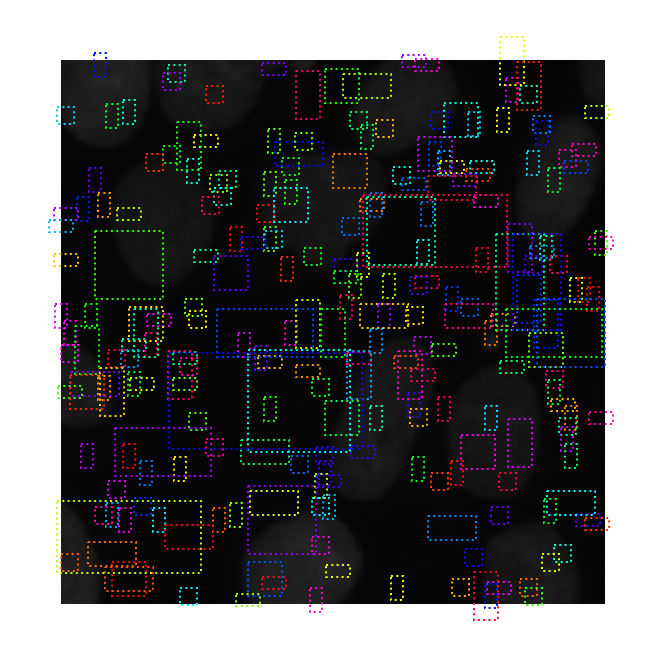

In [11]:
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

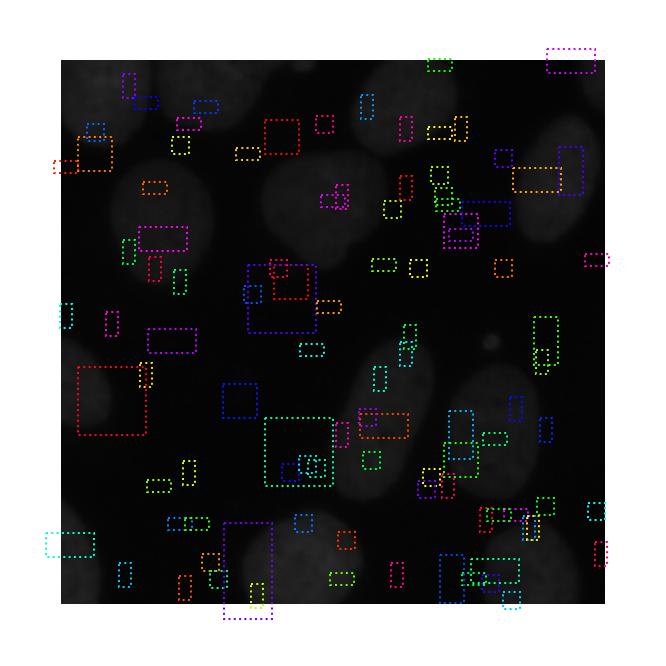

In [12]:
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

Positive ROIs:  27
Negative ROIs:  101
Positive Ratio: 0.21
Unique ROIs: 128 out of 128


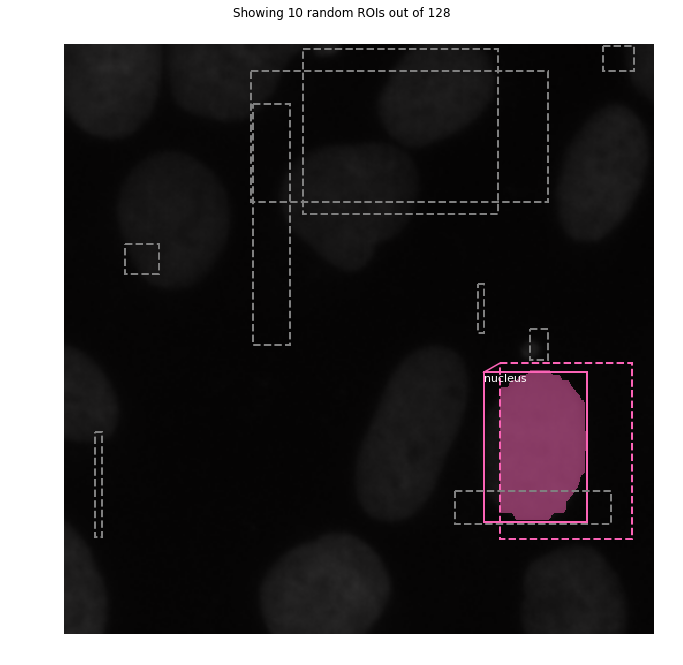

In [13]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

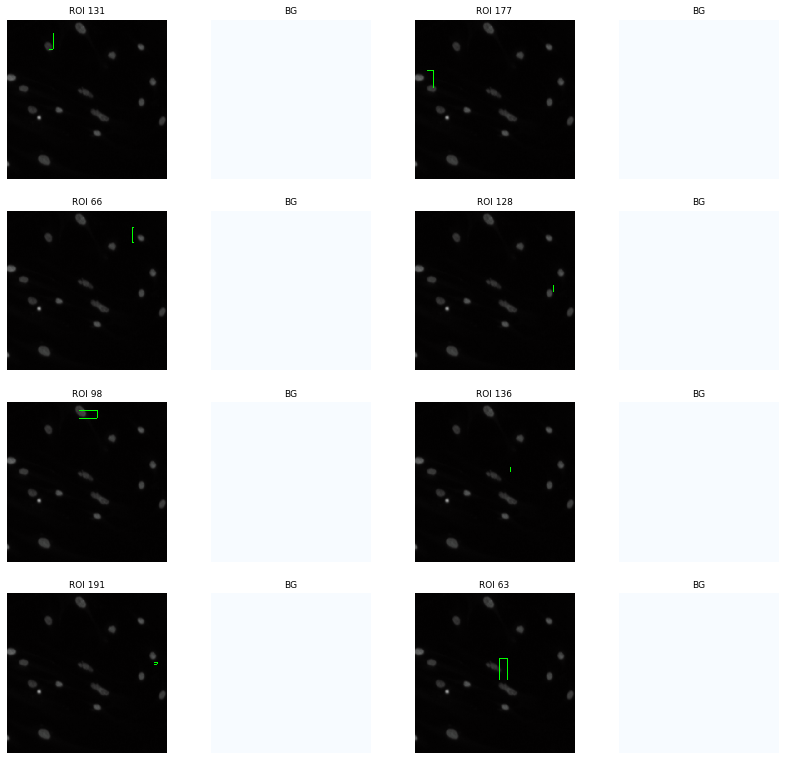

In [28]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [42]:
if random_rois:
    limit = 10
    temp_g = data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
